In [1]:
import numpy as np
from scipy.optimize import fminbound
import seaborn as sns
import matplotlib.pyplot as plt
from math import *

In [2]:
# ====
# TODO: Bellmaan operator T: C(X) -> C(X) where X = [O,Kmax] with Kmax normalized at 1
def bellman_operator(w, grid, beta, u, f, policy=0):
    # " w[i] = w(grid[i]) " > w defined by values taken over the grid
    w_func = lambda x: np.interp(x, grid, w)
    if policy:
        g = np.empty_like(w)
    Tw = np.empty_like(w)
          
    #* tt point de la grid T(w[i]) = max_(k' in [O,y]) { u(y-k') + beta.w_func(k') }      where y = f(grid[i])
    #* need interporlation of w because k' in [0,f(k)] > maybe evluation of w on grid !!
    for i, k in enumerate(grid):
        y = f(k)
        def objective(k_prime,y=y):
            return - u(y-k_prime) - beta * w_func(k_prime)
        k_star = fminbound(objective, x1=1e-5, x2=f(k)) #[x1,x2] = Gamma(k)
        Tw[i] = - objective(k_star)
        
        if policy:
            g[i] = k_star
    
    if policy:
        return Tw,g
    else:
        return Tw

#TODO: Contraction mapping theorem : from initial guess computes Cauchy sequence converging to fixed point solution of the (FE) problem
def solve_optimal_growth(w_initial, grid, beta, u, f, err_max=1e-3, max_iter=500):
    i = 0
    init = bellman_operator(w=w_initial, grid=grid, beta=beta, u=u, f=f,policy=1)
    Tw, policy_function = init[0],init[1] 
    error = np.max(np.abs(Tw - w_initial))
    error_track = np.empty(shape=max_iter)
    error_track[i] = error
    
    if error > err_max:
        w = Tw
        i+=1
    
        while error > err_max and i<max_iter : 
            Bellman_operation = bellman_operator(w=w, grid=grid, beta=beta, u=u, f=f, policy=1)
            w_bellman = Bellman_operation[0]
            error = np.max(np.abs(w_bellman - w))
            print("Iteration "+str(i)+'\n Error is '+str(error)+'\n')
            error_track[i] = error
            w[:] = w_bellman
            i+=1 
        policy_function = Bellman_operation[1]
        return [w,policy_function]
    else:
        return [Tw, policy_function] #initial guess is correct

#TODO: optimal_growth class 
class optimal_growth:
    """
    Constant elasticity of substitution optimal growth model, Cobb-Douglas production
    Capital depreciation at rate delta
        F(K,L) = K^α.L^(1-α) > L normalized at 1
        F(K,1) = K^α
        From constraint:
        > f(k) = (1-delta)k + k^α
    """
    def __init__(self, alpha=0.4, beta=0.96, delta=0.33, sigma=0.9):
        self.alpha, self.beta, self.delta, self.sigma = alpha, beta, delta, sigma
        #* β > take the real interest rate (or from micro data)
        #* alpha > look at capital and labour share : compute w.L/Y and r.K/Y using Y is homogenous of order 1 F_L(.)L + F_K(.)K = F(L,K)
        #* CES utility : U(c) = C^(1-sigma) - 1 / 1 - sigma // sigma->1 alors lim(sigma>1)Utility_CES(c) -> ln(c)
        #* >>> sigma measure or risk aversion : either invest in bonds or equity : infer from portfolio how risk adverse they are 

    def u(self, c):
        " Utility "
        return (c**(1-self.sigma)-1)/(1-self.sigma)
        #return log(c)

    def f(self, k):
        " From constraint : c_t = f(k_t) - k_t+1 "
        return (1-self.delta)*k + k**self.alpha
        #return k**self.alpha
        

In [3]:
OG = optimal_growth()
alpha, beta, delta, sigma= OG.alpha, OG.beta, OG.delta, OG.sigma

grid_max = 1    #! Normalisation de X = [O,kmax] "k=K/kmax"
grid_size = 500
grid = np.linspace(1e-5,grid_max,grid_size)

# TODO: take initial random guess v in C(X)
#initw = np.zeros(grid.shape)
initw = 5 * np.log(grid)

# TODO: solve
solve = solve_optimal_growth(w_initial=initw, grid=grid, beta=beta, u=OG.u, f=OG.f, err_max=1e-3, max_iter=500)
value_funct_approx = solve[0]
policy_corresp_function = solve[1]

Iteration 1
 Error is 10.501365682632525

Iteration 2
 Error is 3.895786487699162

Iteration 3
 Error is 1.6571085806831132

Iteration 4
 Error is 0.6718870672689317

Iteration 5
 Error is 0.320088326808607

Iteration 6
 Error is 0.307284790355427

Iteration 7
 Error is 0.2949933982988804

Iteration 8
 Error is 0.28319366376690613

Iteration 9
 Error is 0.27186591626383727

Iteration 10
 Error is 0.2609912656410387

Iteration 11
 Error is 0.2505504529050899

Iteration 12
 Error is 0.2405281961122805

Iteration 13
 Error is 0.2309070778369806

Iteration 14
 Error is 0.22167079388203348

Iteration 15
 Error is 0.21280396071932994

Iteration 16
 Error is 0.20429180735247066

Iteration 17
 Error is 0.19612013685556828

Iteration 18
 Error is 0.18827532834422467

Iteration 19
 Error is 0.1807443377946214

Iteration 20
 Error is 0.17351456491971273

Iteration 21
 Error is 0.1665739797508028

Iteration 22
 Error is 0.15991102061896445

Iteration 23
 Error is 0.1535145797663775

Iteration 24
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


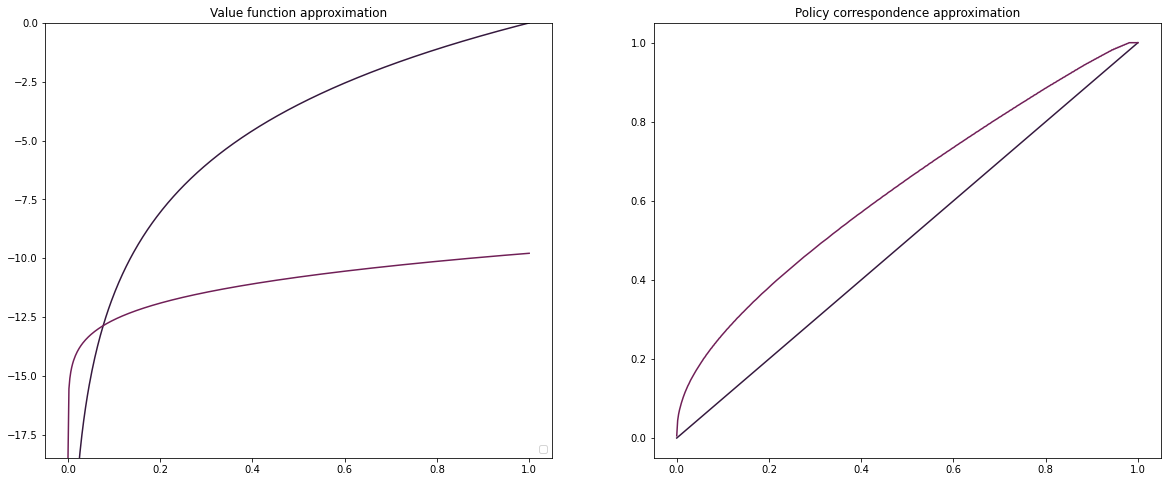

In [8]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.set_palette('rocket')
#fig.suptitle('Prediction results')
axes[0].title.set_text('Value function approximation')
axes[1].title.set_text('Policy correspondence approximation')
axes[0].set(ylim=(np.min(value_funct_approx), 0))
sns.lineplot(ax=axes[0], x=grid, y = initw)
sns.lineplot(ax=axes[0], x=grid, y = value_funct_approx)
sns.lineplot(ax=axes[1], x=grid, y = grid)
sns.lineplot(ax=axes[1], x=grid, y = policy_corresp_function)

axes[0].legend(loc='lower right')

# TODO: CES

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


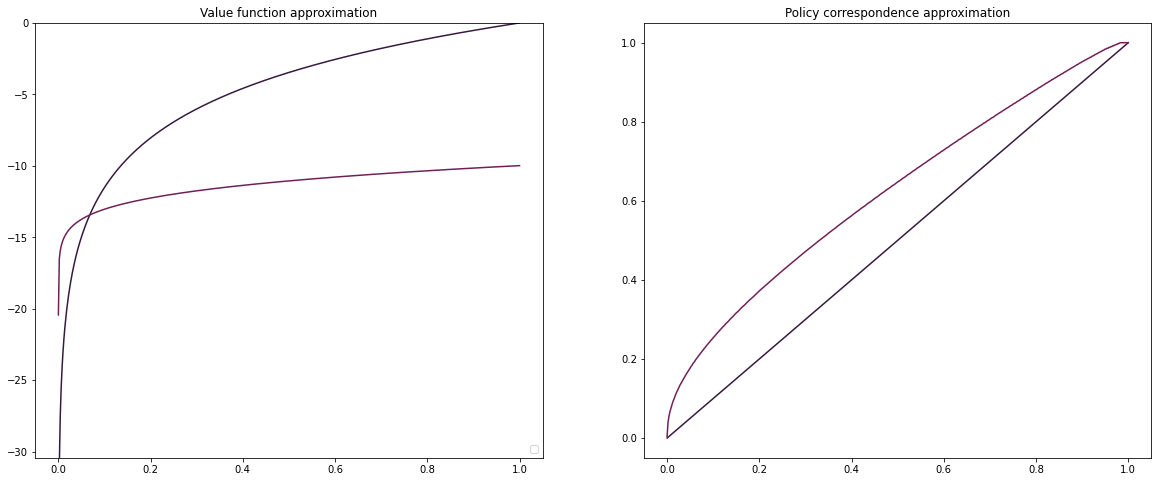

In [142]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.set_palette('rocket')
#fig.suptitle('Prediction results')
axes[0].title.set_text('Value function approximation')
axes[1].title.set_text('Policy correspondence approximation')
axes[0].set(ylim=(np.min(value_funct_approx)-10, 0))
sns.lineplot(ax=axes[0], x=grid, y = initw, legend="full")
sns.lineplot(ax=axes[0], x=grid, y = value_funct_approx)
sns.lineplot(ax=axes[1], x=grid, y = grid)
sns.lineplot(ax=axes[1], x=grid, y = policy_corresp_function)

axes[0].legend(loc='lower right')

# TODO: Ln